# OSMnx features demo

Get street networks anywhere in the world from OpenStreetMap data then analyze and visualize them.

More info:

  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import numpy as np
import geopandas as gpd
import fiona
import osmnx as ox
import requests
import skmob
import pandas as pd
import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

warnings.filterwarnings(action='once')
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.0.1'

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


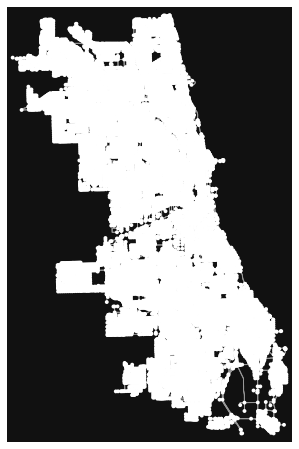

In [2]:
# get the walking network for piedmont
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G)

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


756338315.2232074

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

## Visualize street centrality

In [4]:
# assign speeds and traversal times to the edges
for u, v, k, d in G.edges(keys=True, data=True):
    if 'residential' in d['highway']:
        d['speed'] = 20
    elif 'tertiary' in d['highway']:
        d['speed'] = 30
    elif 'secondary' in d['highway']:
        d['speed'] = 40
    else:
        d['speed'] = 25
    
    # calculate time to traverse edge, in minutes
    d['time'] = d['length'] / (d['speed'] * 1609.34 / 60) #miles/hour to meters/minute

## Importing Crime Data (To be used later)....  for simulating an average crime scenario... Best case, Worst case and Average Crime Rate Data Statistic

In [5]:
data = pd.read_csv('Chicago_Data/all_data_0.5_0_timestamp.csv')
#data = pd.read_csv('Chicago_Data/all_data_worst_case_0_timestamp.csv')
data['user_id']=1

data['Timestamp']=pd.to_datetime(data['Timestamp']).dt.tz_localize(None)
if len(data['Timestamp'].dt.date.unique())==1:
    t0=(data['Timestamp'].dt.date.unique()[0]).strftime('%Y-%m-%d %H:%M:%S')
else:
    print("More Data than one day is passed in, only first day evaluated")
    t0=(data['Timestamp'].dt.date.unique()[0]).strftime('%Y-%m-%d %H:%M:%S')
data['Timestamp']=data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
crime_data = data[[ 'Timestamp','Latitude', 'Longitude','Priority','Service Time']] 
crime_data.head()

,Timestamp,Latitude,Longitude,Priority,Service Time
0,2014-05-07 00:00:00,41.885482,-87.627936,3,0 days 00:19:00
1,2014-05-07 00:00:00,41.898077,-87.729858,3,0 days 00:16:00
2,2014-05-07 00:00:00,41.981052,-87.839659,2,0 days 00:18:00
3,2014-05-07 00:00:00,41.854560,-87.708989,3,0 days 00:27:00
4,2014-05-07 00:01:00,41.747718,-87.684011,2,0 days 00:20:00


## Importing Police Location Data (Using that as location for police for basic simulation)

In [7]:
PS_data = pd.read_csv('Simulation_Data/Police_Stations_-_Map.csv')#, sep = " ", names = ['time', 'lon', 'lat'])
PS_data['user_id']=1

cr_lat=[]
cr_long=[]

for i in range(len(PS_data)):
    s = PS_data['LOCATION'][i]
    s= s[1:-1]
    f = [float(x) for x in s.split(", ")]
    cr_lat.append(f[0])
    cr_long.append(f[1])

PS_data['lat']=cr_lat
PS_data['long']=cr_long


/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
Gs = ox.utils_graph.get_largest_component(G, strongly=True)


In [9]:
PC_node=[]

for i in range(len(PS_data)):
    t = (ox.get_nearest_node(Gs, (cr_lat[i], cr_long[i])))
    PC_node.append(t)


In [10]:
class ndk:
    G=[]
    nodes=[]
    SPL={}
    def calc():
        for i in ndk.nodes:
            ndk.SPL[i]=nx.shortest_path_length(ndk.G, source=i, weight='time')
    def shortest_path_length(G, source, target, weight='none'):
        return ndk.SPL[source][target]
ndk.G=Gs
ndk.nodes=PC_node
ndk.calc()

In [11]:
def Cloning(li1): 
    li_copy = li1[:] 
    return li_copy

In [12]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [13]:
class Police:
    def __init__(self,ID,G,loc,resp,dt):
        self.ID=ID #a unique id
        self.G=G #pointer to the graph the officer travels on (Warning:edits to this graph have global consequences)
        self.loc=loc #the Node that the police officer is at
        self.resp=resp #true if the officer is responding to a crime event, false if patroling
        self.downtime=dt #Remaining time that the police is "down" due to a response event
        self.nodeInd=self.getNodeInd() #the index of the node that the officer is located in list(G.nodes())
    
    #tested
    #Randomly move the officer to an adjacent node if they are not responding
    def walk(self):
        if not(self.resp):
            wk= list(nx.classes.function.all_neighbors(self.G,(list(self.G.nodes)[self.nodeInd])))
            j = np.random.choice(wk)
            self.updateLoc(j)
            
    #moves the police officer toward the node they need to respond to
    def respond(self):
        if self.resp:
            return
    
    #updates the police location (no matter if they are responding or patroling)
    def update(self):
        i.walk()
        i.respond()
        
    #updates the location of the officer to the new Node (and changes the node ID)
    def updateLoc(self,newloc):
        self.loc=newloc
        self.nodeInd=self.getNodeInd()
        
    #gets the index of the node that corresponds to its ID
    def getNodeInd(self):
        return list(self.G.nodes).index(self.loc)

In [14]:
#initialize police officers as a list of variable from the class "Police"
NumberOfPolice=10
#Pol_loc=np.random.choice(len(G.nodes),size=(1,10),replace=False)
Police_officers=[]
for i in range(len(PC_node)):
    Pol_loc=PC_node[i]
    Police_officers.append(Police(i,G,Pol_loc,False,0))


## Evaluating Response time based on the nearest police location to the crime

## Initialize varibales : no of police associated with police location, no of police needed based on crime, 

In [15]:
crime_node=[]

Crime_geo =[]

for i in range(len(crime_data)):
    t = (ox.get_nearest_node(Gs, (crime_data['Latitude'][i], crime_data['Longitude'][i])))
    x = Point(crime_data['Longitude'][i],crime_data['Latitude'][i])
    Crime_geo.append(x)    
    crime_node.append(t)

In [16]:
# This cell is to create time sequence in sec for crime data
# t0 is the time data for the day which is chosen from the crime data analysis.

from datetime import datetime
datetime_object=[]
VG_datetime_object=[]
NVG_datetime_object=[]

# t0 : Time data for the crime day selected. Change this when changing the crime data
#t0 = '2014-08-01 00:00:00'  # worst case day
#t0 = '2014-10-28 00:00:00'  # median case day  

print('Day Evaluating: ',t0)
t_ini = datetime.strptime(t0, '%Y-%m-%d %H:%M:%S')
time_seq=[]  # time_seq is the time sequence in sec for all crime data
VG_time_seq=[]
NVG_time_seq=[]

srvtime_object=[]
ser_time =[] # ser_time is the serive time sequence in sec for all crime data
s0 ='00:00:00'
ss_ini = datetime.strptime(s0, '%H:%M:%S')

for i in range(len(crime_data)):
    datetime_str = crime_data['Timestamp'][i]
    datetime_object.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))
    tt = (datetime_object[i]-t_ini).total_seconds()
    time_seq.append(tt)
    
    srvtime_str = crime_data['Service Time'][i]
    srvtime_object.append(datetime.strptime(srvtime_str[7:-1],'%H:%M:%S'))
    ss = (srvtime_object[i]-ss_ini).total_seconds()
    ser_time.append(ss)
 

Day Evaluating:  2014-05-07 00:00:00


In [17]:
time_min = [x / 60 for x in time_seq]
ser_min = [x / 60 for x in ser_time]
Crime = [time_min,crime_node,ser_min,Crime_geo] #Crime is a list of lists

In [18]:
police = PC_node

## Police Beats

In [19]:

multipol = fiona.open("Simulation_Data/Chicago_PB.shp")
multi= multipol.next()

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


In [20]:
fp = "Simulation_Data/Chicago_PB.shp"
polys  = gpd.read_file(fp)

In [21]:
## This is to change the 33 police beat which is basically water to the surrounding police beat which is land

polys['dist_num'][2] = '16'
polys['dist_num'][3] = '16'
polys['dist_num'][7] = '22'

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
southern = polys[polys['dist_num']=='7']
poly = southern['geometry']

In [23]:
geometry =[Point (xy) for xy in zip(PS_data['long'],PS_data['lat'])]

In [24]:
geo_df = gpd.GeoDataFrame(PS_data,geometry = geometry)

<AxesSubplot:>

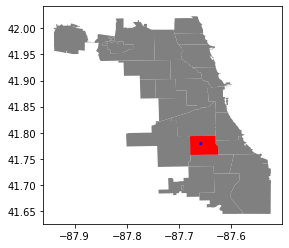

In [25]:
fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray');
southern.plot(ax=ax, facecolor='red');
geo_df[geo_df['DISTRICT'] == '7'].plot(ax=ax, color='blue', markersize=5)


In [26]:
import warnings
warnings.filterwarnings("ignore")

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
## Pre-assigning the Police station node to polys (## done to make the code run faster)

polys['node']=1
for x in range(len(polys)):    
    dis_t= polys['dist_num'][x]        
    te = PS_data[PS_data['DISTRICT'] == dis_t]        
    trr = (ox.get_nearest_node(Gs, (te['lat'].values[0], te['long'].values[0]))) 
    polys['node'][x]=trr
   

In [28]:
##includes staffing numbers of police no per district)
police_staffing=pd.read_csv('Simulation_Data/PoliceBeat_staffing.csv',index_col='assigned_district').drop(columns=['Unnamed: 0'])
police_staffing.index=police_staffing.index.astype(str)
polys=polys.merge(police_staffing[['#Officers']],how='left',left_on='dist_num',right_index=True)
polys['NoOfOfficers']=round(polys['#Officers']/4)


In [29]:
dist_t=0
dis_t not in (polys['dist_num'])

True

In [30]:
### Police dispatch logic according to jurisdiction

def dipatch_logic(polys, pt):
    dis_t=0
    
    ## for loop to check that the point lies in which polygon 
    for x in range(len(polys)): #check how much time this takes?
        if pt.within(polys['geometry'][x]):
            dis_t= polys['dist_num'][x]
            dis_node = polys['node'][x]
            dis_Off = polys['NoOfOfficers'][x]
            
            break
            
                        
    ## if the point is outside the polygons and the point is approximated to the closest polygon
    
    #print('before',dis_t)
    
    #dis_t =0; ## variable to check if the point lied within the boundary   
    
    #if dis_t==0:
    if dis_t not in polys['dist_num'].values:
        #print('in-loop',dis_t)
        dd = 1000000;
        for x in range(len(polys)): 
            t1  = polys['geometry'][x]
            t = gpd.GeoSeries(t1)
            t.crs = 4326

            t2 = gpd.GeoSeries([pt])
            t2.crs = 4326

            dist = t.distance(t2)
            
            if (dist <= dd).bool():
                dd = dist
                dis_t = polys['dist_num'][x]  
                dis_node = polys['node'][x]
                dis_Off = polys['NoOfOfficers'][x]
            
    return (dis_t,dis_node,dis_Off)   

In [31]:
pt = Crime[3][350]
x= dipatch_logic(polys, pt)

southern = polys[polys['dist_num']==x[0]]

<AxesSubplot:>

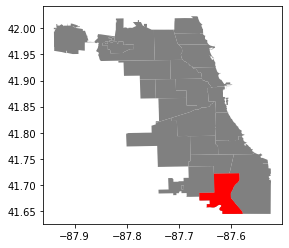

In [32]:
fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray');
southern.plot(ax=ax, facecolor='red');
geo_df[geo_df['DISTRICT'] == x].plot(ax=ax, color='blue', markersize=5)

In [33]:
dipatch_logic(polys, pt)

('5', 261176804, 85.0)

In [34]:
# This is the main cell / function for calculation of response time. Input are the police station node data, crime
# data, no oif officer for a crime, shapefile for police beats and the street network

def eva_resp_time(police,Crime,percent_operating,polys,Gs):
    Resp_time = []
    Officers_maxed_out=0
    orig_node = police

    my_array=[]
    arr_crime = [[0 for i in range(2)] for j in range(len(orig_node))]
    my_array = np.array(arr_crime).astype('int64')
    my_array[:,1]= orig_node 
    PC_stalk = [[0 for i in range(9)] for j in range(len(orig_node))]   #list of 9 things for each police node(23)
    
    ## PC_stalk is the main list which is keeping track of all police station node. 
    # PC_stalk stores the assigned crime to a police station along with when was the crime assigned , its service time,the crimes being actively handles , crimes in waiting queue becuse of officers unavailability
       
            
    for x in range(len(orig_node)):
        PC_stalk[x][0] =orig_node[x] #assign first of nine as police node
    for x in range(len(orig_node)):
        for y in range(3,9):
            PC_stalk[x][y]=[] #assign empty lists for elements 3-9
    columnIndex = 0   
    for j in range(len(Crime[0])): #define attributes of specific crime
        dest_node = Crime[1][j] #dest-node is same as crime_node --> remove?
        Crime_node = Crime[1][j]
        Crime_time = Crime[0][j] 
        Ser_time = Crime[2][j]
        if j !=len(Crime[0])-1:
            Crime_time_next = Crime[0][j+1] #calculate time of next crime  
                        
            
        ## Assign the crime node to police node ny calling the dispatch logic

        pt = Crime[3][j] #geometry of the cime
        (x,s,NoOff)= dipatch_logic(polys, pt) #returns dis_t,dis_node,dis_Off (district #, police node,3officers)
        
        ## if condition is added as sometimes the 'x' output was a string and sometimes it was a number
        # if condition is added to make the output x as a string data

        #if not isinstance(x, str):
         #   x = str(x)
        #te = PS_data[PS_data['DISTRICT'] == x]        
        #trr = (ox.get_nearest_node(Gs, (te['lat'].values[0], te['long'].values[0])))        

        #s = trr
        idx = np.argwhere(column(PC_stalk, 0) == s)[0][0] #assigns index of PC_stalk for the relevant police station node
        
        NoOff=round((NoOff*percent_operating)/2) #apply percent reduction to #officers at district level
    
        
        
        if PC_stalk[idx][1] < NoOff:  # if the officer are avaiable : assign crime as active
            #print(PC_stalk[idx][1],NoOff,x)
            PC_stalk[idx][1]= PC_stalk[idx][1]+1 #keeps track of crimes officers are working on
            PC_stalk[idx][3].append(Crime_time)
            PC_stalk[idx][4].append(Crime_node)
            temp = ndk.shortest_path_length(Gs, PC_stalk[idx][0], Crime_node, weight='time')
            PC_stalk[idx][5].append(2*temp + Crime_time + Ser_time)
            Resp_time.append([temp,Crime_time])

        else : #-->  if officers are already occupied make a waiting queue for all the crimes being assinged
            #print('Officers all Occupied',PC_stalk[idx][1],NoOff,x)
            Officers_maxed_out+=1
            PC_stalk[idx][2]= PC_stalk[idx][2]+1
            PC_stalk[idx][6].append(Crime_node)
            PC_stalk[idx][7].append(Crime_time)
            PC_stalk[idx][8].append(Ser_time)


        if j !=len(Crime[0])-1: #if it's not the end of the crime list
            ## Check if a PC node is going to available
            for idx in range(len(orig_node)): #idx i index corresponding to police station node
                y=0
                while (PC_stalk[idx][1])>0 and y<=PC_stalk[idx][1]-1: #while there is a crime being worked on
                    if PC_stalk[idx][5][y] <= Crime_time_next: #current crime is served before next crime
                        if PC_stalk[idx][2]>0: #if there are crimes in the queue 
                            PC_stalk[idx][2]= PC_stalk[idx][2]-1
                            temp1 = PC_stalk[idx][5][y]
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][3].append(temp1) #update time of crimetime in queue to time previous crime finished
                            temp2 = PC_stalk[idx][6][0]     ##Change from y to 0
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][4].append(temp2)#update crime_node to the one in queue
                            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
                            wait = temp1 - PC_stalk[idx][7][0] #calculates wait time in queue
                            se_time = PC_stalk[idx][8][0]
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                            PC_stalk[idx][5].append(2*temp3 + temp1 + se_time)
                            Resp_time.append([wait+temp3,PC_stalk[idx][7][0]])#why is the time included here?
                            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
                            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
                            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
                        else:
                            PC_stalk[idx][1]= PC_stalk[idx][1]-1
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                    else:
                        y=y+1 #this keeps track of how many crimes are in the queue
                        #confused how this function takes into account if a crime starts after and finishes later
    d=[]
    
    # The for loop below is for all the crime data whole response time index is 
    
    for idx in range(len(orig_node)):
        while PC_stalk[idx][2]>0:
            a = min(PC_stalk[idx][5])
            ind = PC_stalk[idx][5].index(a)
            PC_stalk[idx][2]= PC_stalk[idx][2]-1
            temp1 = PC_stalk[idx][5][ind]
            PC_stalk[idx][3].remove(PC_stalk[idx][3][ind])
            PC_stalk[idx][3].append(temp1)
            temp2 = PC_stalk[idx][6][0]
            PC_stalk[idx][4].remove(PC_stalk[idx][4][ind])
            PC_stalk[idx][4].append(temp2)
            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
            wait = temp1 - PC_stalk[idx][7][0]
            ser_time = PC_stalk[idx][8][0]
            PC_stalk[idx][5].remove(PC_stalk[idx][5][ind])
            PC_stalk[idx][5].append(2*temp3 + temp1 + ser_time)
            d.append([wait+temp3,PC_stalk[idx][7][0]])
            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
    Resp_time.extend(d)
    print("Officers_maxed_out", Officers_maxed_out, " times")
    return Resp_time

In [35]:
percent_operating=0.5 
Resp_time = eva_resp_time(police,Crime,percent_operating,polys,Gs)

Officers_maxed_out 0  times


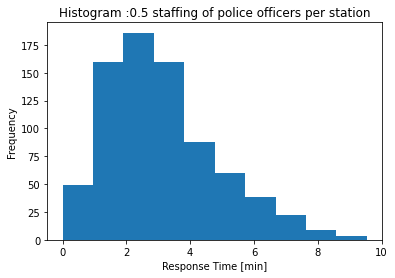

In [36]:
import matplotlib.pyplot as plt

res_time = column(Resp_time, 0)

plt.hist(res_time)
plt.ylabel('Frequency')
plt.xlabel('Response Time [min]')
plt.title("Histogram :" + str(percent_operating) + " staffing of police officers per station");
 
plt.show()


In [37]:
import statistics

print('The median with ' + str(percent_operating*100) + '% officers staffing levels is ', statistics.median(res_time))
avg1 = sum(res_time)/len(res_time)
print('The average with ' + str(percent_operating*100) + '% officers staffing levels is ', round(avg1,2))
print('The max response time with ' + str(percent_operating*100) + '% officers staffing levels is ', max(res_time))

The median with 50.0% officers staffing levels is  2.828272770203935
The average with 50.0% officers staffing levels is  3.11
The max response time with 50.0% officers staffing levels is  9.53565623174717
